In [530]:
import pandas as pd
import matplotlib.pyplot as plt
import functools
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [553]:
def read_pickle(*names):
    for name in names:
        df = pd.read_pickle(f"D:/proj/phd/agge/src/experiment/ipinyou/onehot/{name}.pickle")
        if name=="result__10" or name == "results__3" or name == "results__4":
            yield df[(df.algorithm != "MLP-v0") & (df.algorithm != "DeepWide")]
        elif name=='result__10a_up_to_63' or name=="result__10a_from_64" or name=="result__10c":
            yield df[df.algorithm != "DeepWideV2"]
        else:
            yield df

def read_data(*names):
    return functools.reduce(lambda df0, df1: df0.append(df1), read_pickle(*names))

# df = read_data("result__10", "results__3", "results__4", 
#                "result__10a_up_to_63", "result__10a_from_64", "result__10b", "result__10c")
df = read_data( "multiset_0a")
# df = read_data( "conj_7b", "conj_7a", "conj_6", "conj_5", "conj_4", "conj_3", "conj_0", "conj_1", "conj_2")
df = df.explode("value")
# unify LR parameter
# df.loc[df.C.notna(), 'alpha'] = df[df.C.notna()].C
# bins removed from OH
df.loc[df.encoding == 'oh', 'bins'] = "N/A"
df.loc[df.a.isna(),'a'] = "0"
df.encoding = df.encoding + '_' + df.a
# df = df[(df.subject=='2261') | (df.subject=='2821') | (df.subject=='2997')]
df.shape

(2240, 21)

D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
C:\Users\rwiat\AppData\Local\Temp/ipykernel_12336/2863929129.py:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  custom_lines = [ mpatches.Patch([0], [0], color=cmap(idx), lw=4) for idx in range(len(sample.encoding.unique()))]
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
C:\Users\rwiat\AppData\Local\Temp/ipykernel_12336/2863929129.py:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  custom_lines = [ mpatches.Patch([0], [0], color=cmap(idx), lw=4) for idx in range(len(sample.encoding.unique()))

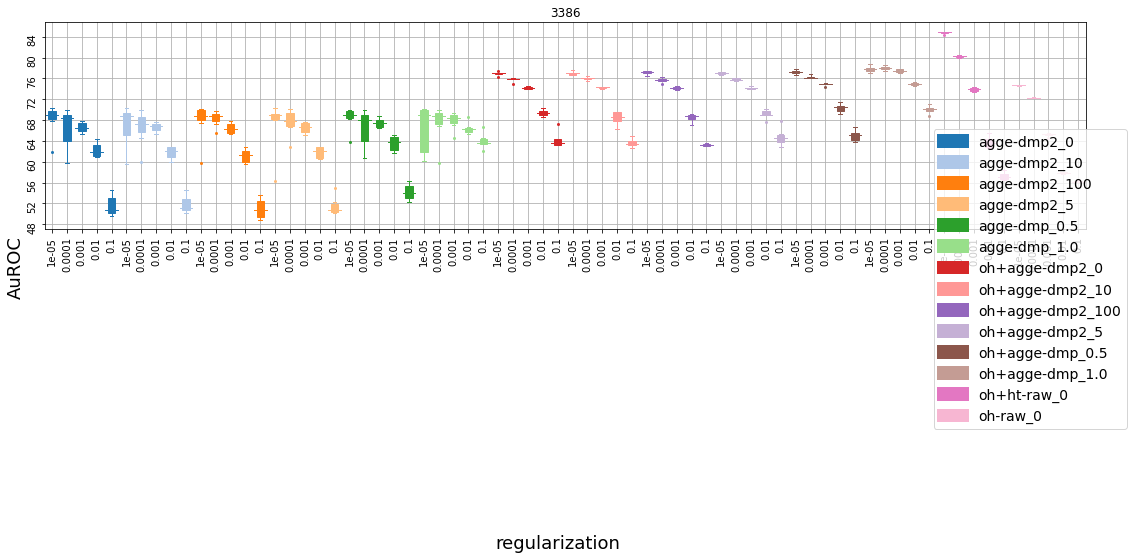

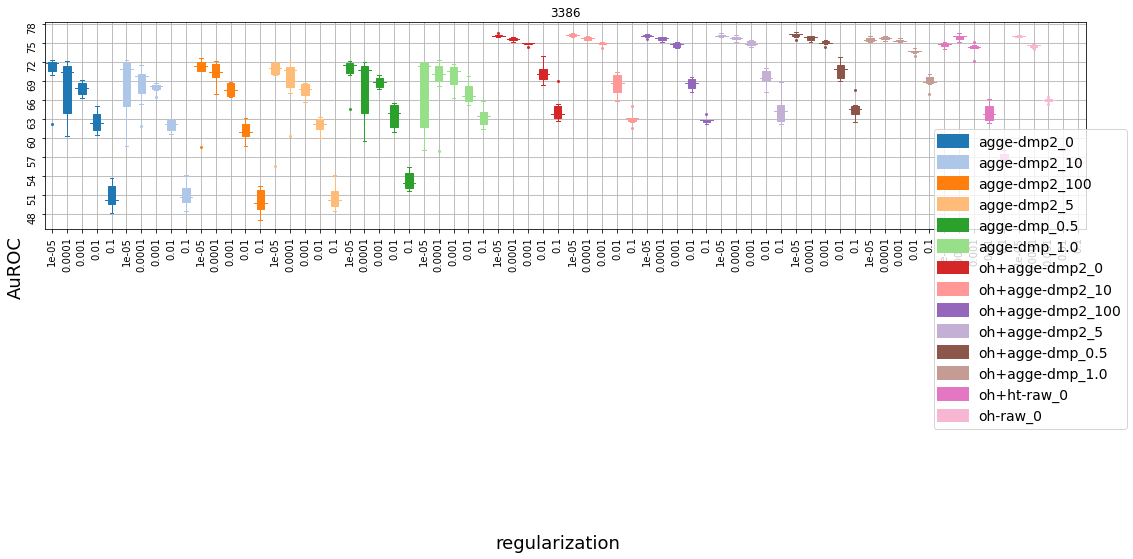

In [540]:
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib.patches import Rectangle, PathPatch
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as ticker
import itertools



def plot_sample(sample, multialpha=True, step=1, rows=1, legend_loc = 'center right', legend_bbox_to_anchor=None,
                axis_desc_fontsize=14, cmap="tab20"):
    fig, axs = plt.subplots(ncols=-(len(sample.subject.unique())//-rows), nrows=rows, figsize=(16, 4*rows))
    fig.tight_layout(pad=4.0)
    axs = [axs] if len(sample.subject.unique()) == 1 else axs
    if rows > 1:
        axs = [item for sublist in axs for item in sublist]
    
#     cmap = plt.get_cmap("Set2")
    cmap = plt.get_cmap(cmap)

    for idx, subject in enumerate(sample.subject.unique()): # palette="deep",
        axs[idx].set_title(subject)

    #     ax = sns.boxplot(x="encoding", y="value", hue="alpha", data=sample[sample.subject == subject], ax=axs[idx],
    #                      showfliers = True, palette="deep", width=0.9)
        dat = sample[sample.subject == subject]
    #     dat.boxplot(by=["encoding", 'alpha'], column="value", ax=axs[idx])
        alphas = dat.alpha.unique().tolist()
        alphas = sorted(alphas)

        def data(df):
            for encoding in df.encoding.unique():
                for alpha in alphas:
                    ret = df[(df.alpha == alpha) & (df.encoding == encoding)].value
                    if ret.shape[0] > 0:
                        yield ret, alpha, encoding
                    else:
                        print(f'skip {alpha}, {encoding}, {ret}')
        
        _nums = []
        _alphas = []
        _encodings = []
        for n, a, e in data(dat):
            _nums.append(n)
            _alphas.append(a)
            _encodings.append(e)
#         print(_alphas, _encodings, _nums)
        bplot = axs[idx].boxplot(_nums,
                                 vert=True,  
                                 patch_artist=True, 
                                 labels=_alphas,
                                 medianprops = dict(linestyle='-', linewidth=1, color='black'))
        colors = np.repeat([cmap(enc_id) for enc_id in range(len(dat.encoding.unique()))], 
                           len(alphas) if multialpha else 1, axis=0)
#         print(dat.encoding.unique())
    #     colors = ['pink', 'lightblue', 'lightgreen']
#         print({k:len(bplot[k]) for k in bplot.keys()})
        def set_color(o, color):
            if hasattr(o, 'set_facecolor'):
                o.set_facecolor(color)
            if hasattr(o, 'get_color'):
                o.set_color(color)
            if hasattr(o, 'get_edgecolor'):
                o.set_edgecolor(color)   
            if hasattr(o, 'set_markeredgecolor'):
                o.set_markeredgecolor(color)   
            if hasattr(o, 'set_markerfacecolor'):
                o.set_markerfacecolor(color)   


        for o, color in zip(bplot['boxes'], colors.tolist()):
            set_color(o, color)

        for o, color in zip(bplot['fliers'], colors.tolist()):
            set_color(o, color)
            o.set_markersize(2)

        for o, color in zip(bplot['whiskers'], np.repeat(colors.tolist(), 2, axis=0)):
            set_color(o, color)

        for o, color in zip(bplot['caps'], np.repeat(colors.tolist(), 2, axis=0)):
            set_color(o, color)
            
        for median, color in zip(bplot['medians'], colors.tolist()):
#             median.set(color='k', linewidth=1,)
            x,y = median.get_data()
            xn = (x-(x.sum()/2.))*0.5+(x.sum()/2.)
            axs[idx].plot([xn - 0.3, xn + 0.3], [y, y], color=color, zorder=4, antialiased=False, linewidth=1)

        axs[idx].tick_params(rotation=90)
        axs[idx].yaxis.set_major_locator(ticker.MultipleLocator(step))
        axs[idx].grid()
        
    for ax in axs[idx+1:]:
        ax.axis('off')
    import matplotlib.patches as mpatches
    custom_lines = [ mpatches.Patch([0], [0], color=cmap(idx), lw=4) for idx in range(len(sample.encoding.unique()))]
    fig.text(0.5, 0.02, 'regularization', ha='center', va='center', fontsize=axis_desc_fontsize)
    fig.text(0.03, 0.5, 'AuROC', ha='center', va='center', rotation='vertical', fontsize=axis_desc_fontsize)
    fig.legend(handles=custom_lines, labels=sample.encoding.unique().tolist(), loc=legend_loc, 
               bbox_to_anchor=legend_bbox_to_anchor, fontsize=axis_desc_fontsize-4)
    # Set common labels

    
sample = df
# sample = sample[sample.encoding!="oh-raw_0"]
# sample = sample[sample.encoding!="oh+ht-raw_0"]
# sample = sample[sample.encoding!="agge-dmp2_0"]
# sample = sample[sample.encoding!="agge-dmp2_5"]
# sample = sample[sample.encoding!="agge-dmp2_10"]
# sample = sample[sample.encoding!="agge-dmp2_100"]
# sample = sample[sample.encoding!="agge-dmp_0.5"]
# sample = sample[sample.encoding!="agge-dmp_1.0"]
# sample = df[df.subject == '2997']
sample.alpha = sample.alpha.astype('float')
sample = sample.sort_values(['encoding', 'alpha']).reset_index()

# sample = sample[((sample.measure_type == "auc_test"))]   
plot_sample(sample[((sample.measure_type == "auc_train"))], step=4, rows=2, axis_desc_fontsize=18)
plot_sample(sample[((sample.measure_type == "auc_test"))], step=3, rows=2, axis_desc_fontsize=18)
# plot_sample(sample[sample.alpha==0.01])


In [541]:
sample.encoding.unique()

array(['agge-dmp2_0', 'agge-dmp2_10', 'agge-dmp2_100', 'agge-dmp2_5',
       'agge-dmp_0.5', 'agge-dmp_1.0', 'oh+agge-dmp2_0',
       'oh+agge-dmp2_10', 'oh+agge-dmp2_100', 'oh+agge-dmp2_5',
       'oh+agge-dmp_0.5', 'oh+agge-dmp_1.0', 'oh+ht-raw_0', 'oh-raw_0'],
      dtype=object)

In [542]:
sample

,index,measure_type,value,algorithm,subject,encoding,features,conj,bins,a,hidden_layer_sizes,alpha,batch_size,learning_rate_init,max_iter,validation_fraction,tol,early_stopping,beta_1,beta_2,epsilon,n_iter_no_change
0,0,auc_train,69.84244,DmpRegV3,3386,agge-dmp2_0,196,False,33,0,"(32, 4)",0.00001,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
1,0,auc_train,70.361344,DmpRegV3,3386,agge-dmp2_0,196,False,33,0,"(32, 4)",0.00001,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
2,1,auc_test,72.069384,DmpRegV3,3386,agge-dmp2_0,196,False,33,0,"(32, 4)",0.00001,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
3,1,auc_test,72.302287,DmpRegV3,3386,agge-dmp2_0,196,False,33,0,"(32, 4)",0.00001,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
4,2,auc_best_model_test,72.069384,DmpRegV3,3386,agge-dmp2_0,196,False,33,0,"(32, 4)",0.00001,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,349,delta,53.888647,RegV2,3386,oh-raw_0,564,False,33,0,"(32, 4)",0.10000,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
2236,349,delta,52.100191,RegV2,3386,oh-raw_0,564,False,33,0,"(32, 4)",0.10000,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
2237,349,delta,53.924628,RegV2,3386,oh-raw_0,564,False,33,0,"(32, 4)",0.10000,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5
2238,349,delta,53.116813,RegV2,3386,oh-raw_0,564,False,33,0,"(32, 4)",0.10000,1000,0.001,50,0.0,0.0001,False,0.9,0.999,1e-08,5


In [543]:
sample = sample[((sample.measure_type == "auc_test"))]
mmx = sample[['algorithm', 'alpha', 'value', 'encoding', 'subject']]\
.groupby(['algorithm', 'alpha', 'encoding', 'subject']).median().groupby(['algorithm', 'encoding', 'subject']).idxmax()
print(mmx)
max_sample = None
for maxed in mmx.reset_index().value:
    _df = sample[(sample.algorithm == maxed[0]) & 
                 (sample.alpha == maxed[1]) & 
                 (sample.encoding == maxed[2]) & 
                 (sample.subject == maxed[3])].copy()
    max_sample = _df if max_sample is None else _df.append(max_sample, ignore_index=True)
max_sample = max_sample.sort_values(['encoding', 'alpha']).reset_index()


                                                                        value
algorithm encoding         subject                                           
DmpRegV2  agge-dmp_0.5     3386         (DmpRegV2, 1e-05, agge-dmp_0.5, 3386)
          agge-dmp_1.0     3386         (DmpRegV2, 1e-05, agge-dmp_1.0, 3386)
          oh+agge-dmp_0.5  3386      (DmpRegV2, 1e-05, oh+agge-dmp_0.5, 3386)
          oh+agge-dmp_1.0  3386     (DmpRegV2, 0.0001, oh+agge-dmp_1.0, 3386)
DmpRegV3  agge-dmp2_0      3386          (DmpRegV3, 1e-05, agge-dmp2_0, 3386)
          agge-dmp2_10     3386         (DmpRegV3, 1e-05, agge-dmp2_10, 3386)
          agge-dmp2_100    3386        (DmpRegV3, 1e-05, agge-dmp2_100, 3386)
          agge-dmp2_5      3386          (DmpRegV3, 1e-05, agge-dmp2_5, 3386)
          oh+agge-dmp2_0   3386       (DmpRegV3, 1e-05, oh+agge-dmp2_0, 3386)
          oh+agge-dmp2_10  3386      (DmpRegV3, 1e-05, oh+agge-dmp2_10, 3386)
          oh+agge-dmp2_100 3386     (DmpRegV3, 1e-05, oh+agge-dm

In [544]:
(max_sample[max_sample.encoding == 'oh+agge'].groupby('subject')['value'].mean()-\
max_sample[max_sample.encoding == 'oh'].groupby('subject')['value'].mean()).mean()

nan

In [545]:
(max_sample[max_sample.encoding == 'oh+ht'].groupby('subject')['value'].mean()-\
max_sample[max_sample.encoding == 'oh'].groupby('subject')['value'].mean()).mean()

nan

In [546]:
(max_sample[max_sample.encoding == 'oh+agge'].groupby('subject')['value'].mean()-\
max_sample[max_sample.encoding == 'oh+ht'].groupby('subject')['value'].mean()).mean()

nan

skip 0.0001, oh+agge-dmp2_0, Series([], Name: value, dtype: object)
skip 0.0001, oh+agge-dmp2_10, Series([], Name: value, dtype: object)
skip 0.0001, oh+agge-dmp2_100, Series([], Name: value, dtype: object)
skip 0.0001, oh+agge-dmp2_5, Series([], Name: value, dtype: object)
skip 0.0001, oh+agge-dmp_0.5, Series([], Name: value, dtype: object)
skip 1e-05, oh+agge-dmp_1.0, Series([], Name: value, dtype: object)
skip 1e-05, oh+ht-raw_0, Series([], Name: value, dtype: object)
skip 0.0001, oh-raw_0, Series([], Name: value, dtype: object)


D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
C:\Users\rwiat\AppData\Local\Temp/ipykernel_12336/2863929129.py:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  custom_lines = [ mpatches.Patch([0], [0], color=cmap(idx), lw=4) for idx in range(len(sample.encoding.unique()))]


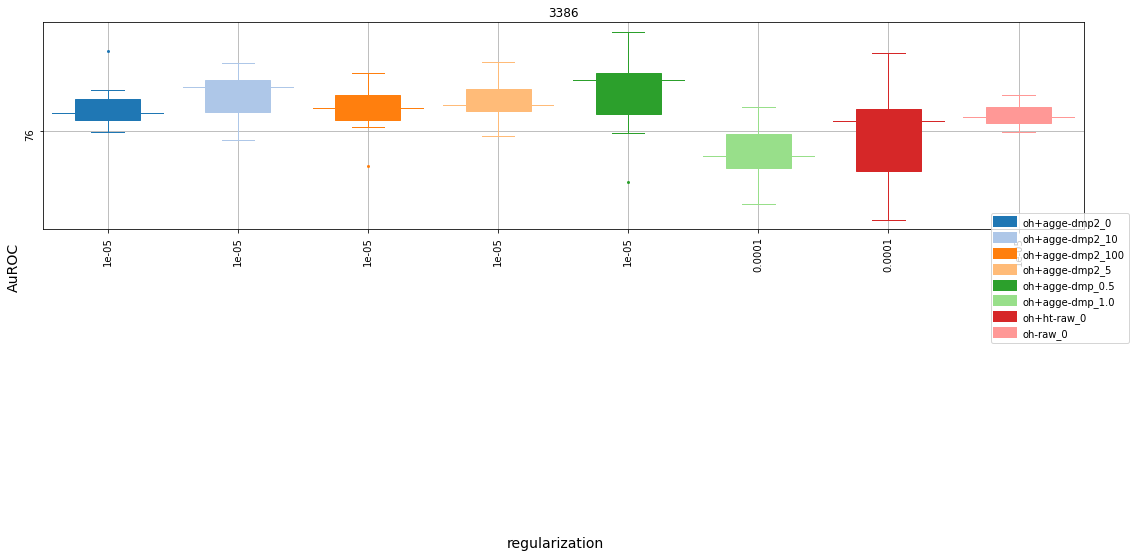

In [550]:
max_sample=max_sample[max_sample.encoding!='agge-dmp2_0']
max_sample=max_sample[max_sample.encoding!='agge-dmp2_10']
max_sample=max_sample[max_sample.encoding!='agge-dmp2_100']
max_sample=max_sample[max_sample.encoding!='agge-dmp2_5']
max_sample=max_sample[max_sample.encoding!='agge-dmp_0.5']
max_sample=max_sample[max_sample.encoding!='agge-dmp_1.0']
plot_sample(max_sample[max_sample.encoding!='oh'], multialpha=False, rows=2, step=1)


In [478]:
##############################################
### RESULTS PART 1
##############################################
df = read_data( "conj_7b", "conj_7a", "conj_6", "conj_5", "conj_4", "conj_3", "conj_0", "conj_1", "conj_2")
df.loc[df.C.notna(), 'alpha'] = df[df.C.notna()].C
df.loc[df.encoding == 'oh', 'bins'] = "N/A"
df = df.explode("value")

D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison f

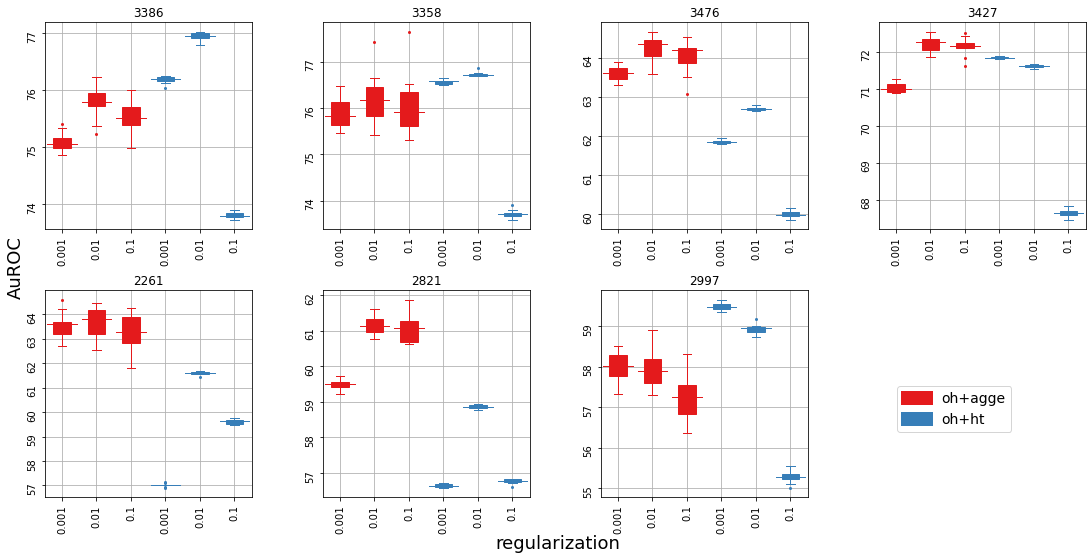

In [480]:
sample = df
sample.alpha = sample.alpha.astype('float')
sample = sample.sort_values(['encoding', 'alpha']).reset_index()
# sample = sample[sample.encoding!='oh']
sample = sample[sample.encoding!='agge']
plot_sample(sample[((sample.measure_type == "auc_test")&(sample.encoding!='oh'))], step=1, rows=2, legend_loc='lower right', 
            legend_bbox_to_anchor=(0.9, 0.2), axis_desc_fontsize=18, cmap="Set1")


                                                          value
algorithm  encoding subject                                    
SKLearn-LR oh       2261            (SKLearn-LR, 0.1, oh, 2261)
                    2821            (SKLearn-LR, 0.1, oh, 2821)
                    2997            (SKLearn-LR, 0.1, oh, 2997)
                    3358            (SKLearn-LR, 0.1, oh, 3358)
                    3386            (SKLearn-LR, 0.1, oh, 3386)
                    3427            (SKLearn-LR, 0.1, oh, 3427)
                    3476            (SKLearn-LR, 0.1, oh, 3476)
           oh+agge  2261      (SKLearn-LR, 0.01, oh+agge, 2261)
                    2821      (SKLearn-LR, 0.01, oh+agge, 2821)
                    2997     (SKLearn-LR, 0.001, oh+agge, 2997)
                    3358      (SKLearn-LR, 0.01, oh+agge, 3358)
                    3386      (SKLearn-LR, 0.01, oh+agge, 3386)
                    3427      (SKLearn-LR, 0.01, oh+agge, 3427)
                    3476      (SKLearn-L

D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison f

skip 0.001, oh+agge, Series([], Name: value, dtype: object)
skip 0.01, oh+ht, Series([], Name: value, dtype: object)


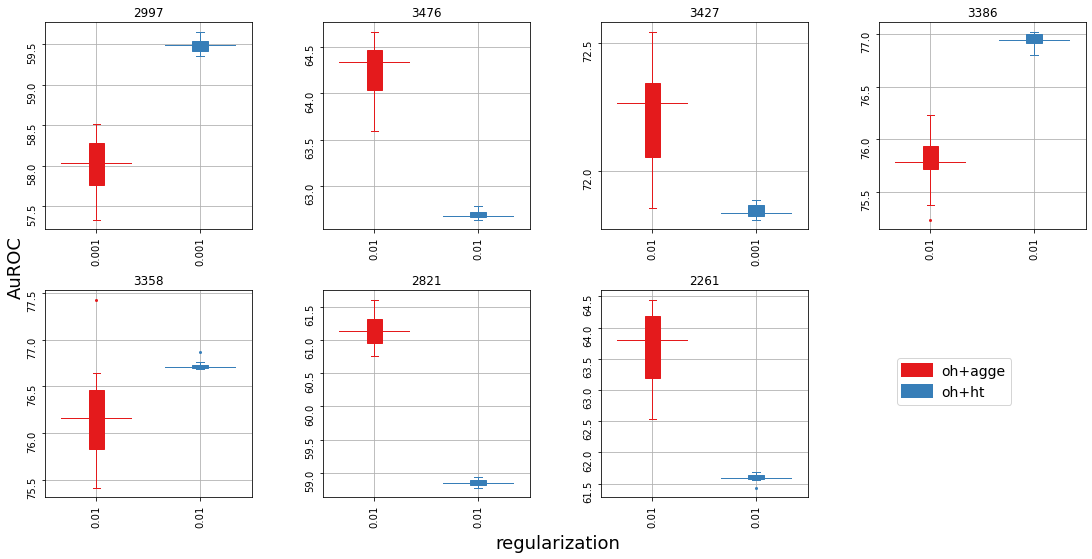

In [347]:
sample = sample[((sample.measure_type == "auc_test"))]
mmx = sample[['algorithm', 'alpha', 'value', 'encoding', 'subject']]\
.groupby(['algorithm', 'alpha', 'encoding', 'subject']).median().groupby(['algorithm', 'encoding', 'subject']).idxmax()
print(mmx)
max_sample = None
for maxed in mmx.reset_index().value:
    _df = sample[(sample.algorithm == maxed[0]) & 
                 (sample.alpha == maxed[1]) & 
                 (sample.encoding == maxed[2]) & 
                 (sample.subject == maxed[3])].copy()
    max_sample = _df if max_sample is None else _df.append(max_sample, ignore_index=True)
max_sample = max_sample.sort_values(['encoding', 'alpha']).reset_index()

plot_sample(max_sample[(max_sample.encoding!='oh')], multialpha=False, rows=2, legend_bbox_to_anchor=(0.9, 0.3), axis_desc_fontsize=18, cmap="Set1",
           step=0.5)


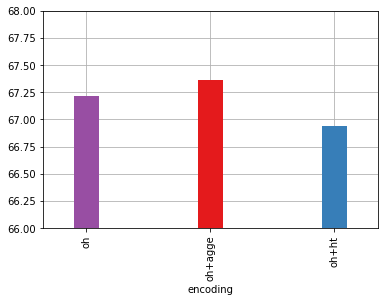

In [403]:
max_sample['AuROC'] = max_sample.value
max_sample.features = max_sample.features.astype(int)
to_plot = max_sample.groupby('encoding')['AuROC'].mean()
to_plot.plot.bar(color={plt.get_cmap("Set1")(3): "NA",  
                        plt.get_cmap("Set1")(0): "NA", 
                        plt.get_cmap("Set1")(1): "NA"},
                 width = 0.2)
plt.grid()
plt.ylim([66, 68])

x = np.linspace(-100, 100)
y = np.repeat(float(to_plot.oh), x.shape[0])
# axes2 = plt.twinx()
# axes2.plot(x, y, color='k', linestyle=':', linewidth=1)

# axes2.set_ylim(-1, 1)
# axes2.set_ylabel('Line plot')

plt.ylim([66, 68])
plt.rc('axes', axisbelow=True)

In [406]:
to_plot = max_sample.groupby('encoding')['features'].mean()

In [407]:
to_plot

encoding
oh          556.000000
oh+agge    4804.608696
oh+ht      4805.898551
Name: features, dtype: float64